#### iLQR for point mass example

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import dot
from numpy.linalg import inv
from IPython.display import clear_output
import time
from ocp import *
from costs import *
%load_ext autoreload
%autoreload 2

np.set_printoptions(precision=4, suppress=True)

#### Create point mass system with dimension 2 (double integrator)

In [56]:
dt = 0.05
T = 100
Dx, Du = 4, 2
A = np.eye(Dx)
A[:2,2:] = np.eye(2)*dt
B = np.zeros((Dx, Du))
B[2:, :] = np.eye(Du)

sys = LinearSystem(A, B)

#### Set initial state and control trajectory

In [57]:
x0 = np.zeros(Dx)
x0[3] = 0
sys.set_init_state(x0)

#set initial control output to be all zeros
us = np.zeros((T+1,sys.Du))
_ = sys.compute_matrices(x0, us[0])
xs = sys.rollout(us[:-1])

#### Plot initial trajectory

#### Set the regularization cost coefficients Q and R 

In [97]:
Q = np.eye(sys.Dx)*1
#Q[0:2,0:2] *= 0.0
Qf = np.eye(sys.Dx)*1
#Qf[0:2,0:2] *= 0.0
R = np.eye(sys.Du)*.001
mu = 1e-6

#### Set reference target

In [98]:
x_ref = np.array([2, 2, 0,0])

#### Set obstacle

In [114]:
p_obs1 = np.array([1.,0.6])
Sigma_obs1 = np.diag([0.3, 0.3])
w_obs1 = 100
r_obs1 = np.sqrt(0.3)

### iLQR using cost model

#### Define the cost

In [115]:
#The costs consist of: a) state tracking (Q), b) control regularization (R)
#Running cost is for the time 0 <= t < T, while terminal cost is for the time t = T
costs = []

for i in range(T):
    runningStateCost = CostModelQuadratic(sys, Q, x_ref = x_ref)
    runningControlCost = CostModelQuadratic(sys, None, R)
    runningObstacleCost = CostModelCollisionEllipsoid(sys, p_obs1, Sigma_obs1, w_obs1)
#     activation = ActivationCollision(nr=2, threshold = r_obs1)
#     runningObstacleCost = CostModelCollisionCircle(sys, activation, p_obs1, Sigma_obs1, w_obs1)
    
    runningCost = CostModelSum(sys, [runningStateCost, runningControlCost, runningObstacleCost])
    costs += [runningCost]

terminalStateCost = CostModelQuadratic(sys,Qf, x_ref = x_ref)
terminalControlCost = CostModelQuadratic(sys, None,R)
terminalObstacleCost = CostModelCollisionEllipsoid(sys, p_obs1, Sigma_obs1, w_obs1)
# activation = ActivationCollision(nr=2, threshold = r_obs1)
# terminalObstacleCost = CostModelCollisionCircle(sys, activation, p_obs1, Sigma_obs1, w_obs1)
terminalCost = CostModelSum(sys, [terminalStateCost, terminalControlCost, terminalObstacleCost])

costs += [terminalCost]

#### Construct ILQR

In [116]:
ilqr_cost = ILQR(sys)
ilqr_cost.set_init_state(x0)
ilqr_cost.set_timestep(T)
ilqr_cost.set_cost(costs)
ilqr_cost.set_state(xs, us)

#### Solve and Plot

#### Solve

In [117]:
n_iter = 10
ilqr_cost.solve(n_iter, method='batch')
xs_batch, us_batch = ilqr_cost.xs, ilqr_cost.us


#clear_output()

404.0
(1.0, 246.50231297822177)
246.50231297822177
(1.0, 1842.0561538274721)
(0.8, 1209.8835866938855)
(0.6400000000000001, 805.2931437283899)
(0.5120000000000001, 546.3552602304729)
(0.40960000000000013, 380.63501479180593)
(0.32768000000000014, 274.574057711059)
(0.2621440000000001, 206.69504517938094)
206.69504517938094
(1.0, 246.50231297823683)
(0.8, 90.84819712531669)
90.84819712531669
(1.0, 246.50231297822728)
(0.8, 175.4404023255695)
(0.6400000000000001, 129.09758761429416)
(0.5120000000000001, 103.60710552144977)
(0.40960000000000013, 92.15127749107029)
(0.32768000000000014, 88.71038887319483)
88.71038887319483
(1.0, 93.07031585317975)
(0.8, 91.82479445791752)
(0.6400000000000001, 90.92632520635418)
(0.5120000000000001, 90.27023643847716)
(0.40960000000000013, 89.78548486953468)
(0.32768000000000014, 89.42336005941063)
(0.2621440000000001, 89.15009313613048)
(0.2097152000000001, 88.94199666939056)
(0.1677721600000001, 88.78225042200458)
(0.13421772800000006, 88.65876121673956)


In [118]:
idx = -1

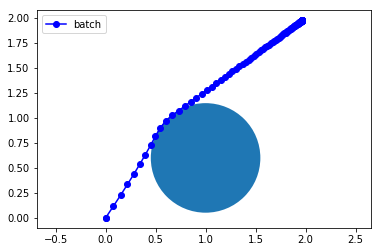

In [119]:
fig, ax = plt.subplots()
ax.plot(xs_batch[:idx,0], xs_batch[:idx,1], 'b-o', label='batch')
ax.plot(p_obs1[0], p_obs1[1], 'o', markersize=10)
c1 = plt.Circle(p_obs1, radius=r_obs1)
ax.add_patch(c1)
ax.legend()
plt.axis('equal')
plt.show()

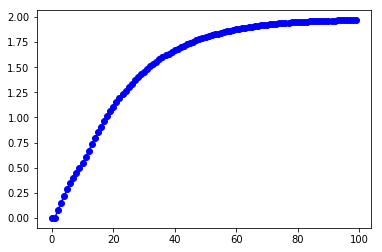

In [120]:
plt.plot(xs_batch[:idx,0],'b-o', label='batch')

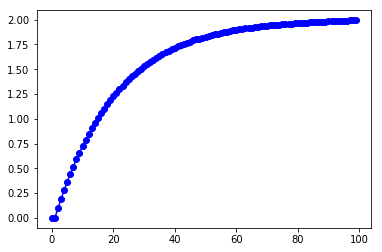

In [92]:
plt.plot(xs_batch[:idx,1],'b-o', label='batch')

#### Print obstacle costs

In [93]:
ilqr_cost.costs[0].Lxx

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [96]:
for i in range(T+1):
    cost_obs = ilqr_cost.costs[i].costs[-1]
    print(i, cost_obs.L, cost_obs.obs_status)

(0, 0, False)
(1, 0, False)
(2, 0, False)
(3, 0, False)
(4, 0, False)
(5, 0, False)
(6, 0, False)
(7, 0, False)
(8, -4.335882355614585, True)
(9, -3.6757263656910006, True)
(10, -3.3281393474969487, True)
(11, -3.2587273973308504, True)
(12, -3.43056618547228, True)
(13, -3.804444166716295, True)
(14, -4.340414619266479, True)
(15, 0, False)
(16, 0, False)
(17, 0, False)
(18, 0, False)
(19, 0, False)
(20, 0, False)
(21, 0, False)
(22, 0, False)
(23, 0, False)
(24, 0, False)
(25, 0, False)
(26, 0, False)
(27, 0, False)
(28, 0, False)
(29, 0, False)
(30, 0, False)
(31, 0, False)
(32, 0, False)
(33, 0, False)
(34, 0, False)
(35, 0, False)
(36, 0, False)
(37, 0, False)
(38, 0, False)
(39, 0, False)
(40, 0, False)
(41, 0, False)
(42, 0, False)
(43, 0, False)
(44, 0, False)
(45, 0, False)
(46, 0, False)
(47, 0, False)
(48, 0, False)
(49, 0, False)
(50, 0, False)
(51, 0, False)
(52, 0, False)
(53, 0, False)
(54, 0, False)
(55, 0, False)
(56, 0, False)
(57, 0, False)
(58, 0, False)
(59, 0, Fal

#### Check derivative

In [146]:
x = np.array([1., .9, 0, 0])
u = np.zeros(2)

cost0 = runningObstacleCost.calc(x, u)
print(cost0)

-0.16000000000000003


In [130]:
J = np.zeros(2)
inc = 0.001
for i in range(2):
    xn = x.copy()
    xn[i] += inc
    costn = runningObstacleCost.calc(xn, u)
    dc = (costn-cost0)/inc
    print(costn)
    J[i] = dc
print(J)

runningObstacleCost.calc(x, u)

runningObstacleCost.calcDiff(x, u)
print(runningObstacleCost.Lx)

-0.0003831179667335694
-0.00035821429009708186
[-0.0271 -0.0022]
[-0.0266 -0.0017  0.      0.    ]
